# GA 기반 정비 스케줄링 최적화
2022.04.24 민수홍

GA를 활용한 정비스케줄링

## Library

In [25]:
### library
requiredPackages = c('tidyverse', 'GA')

for(p in requiredPackages){
  if(!require(p,character.only = TRUE)) install.packages(p)
  library(p,character.only = TRUE)
}


In [26]:
work_path = 'D:\\Google 드라이브\\연구실\\SKT fellowship'
setwd(work_path)

risk_info = read.csv('data\\risk_cdf.csv') # Dataset

## Risk Information Visualization

In [27]:
options(repr.plot.width=9, repr.plot.height=7)

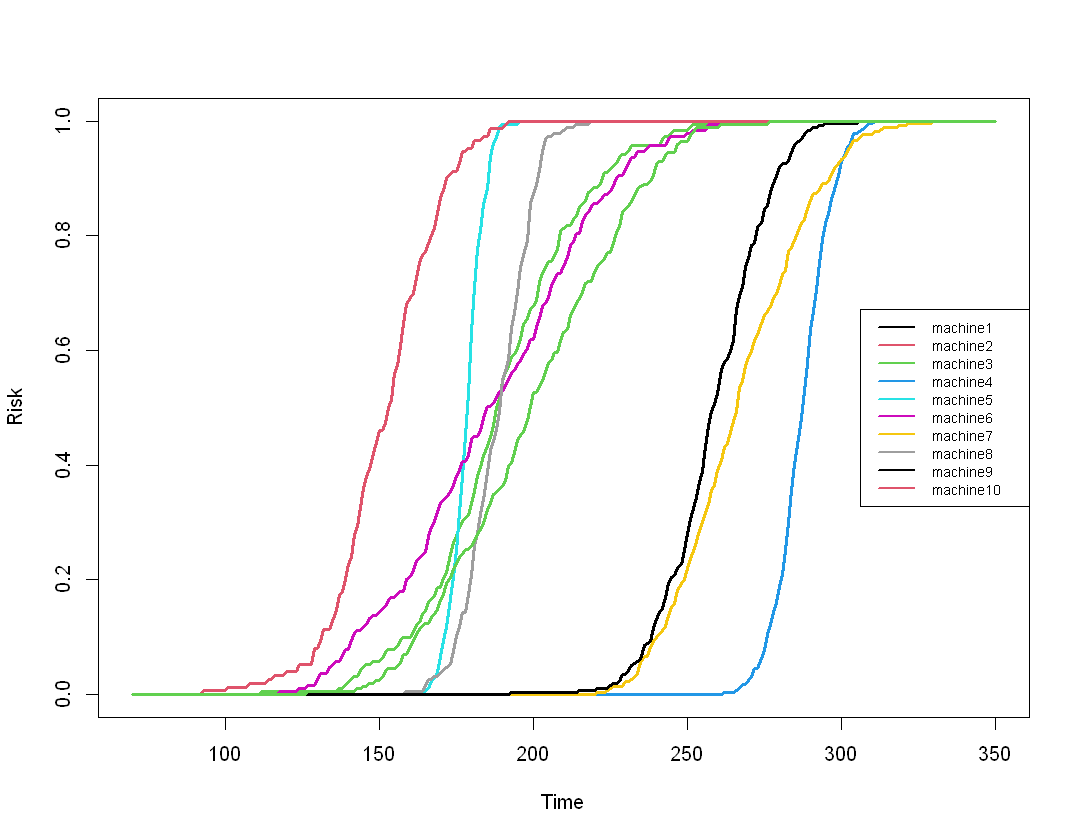

In [28]:
par(mfrow = c(1,1))
plot(risk_info[70:350, 1], risk_info[70:350,2] , type = 'l', lwd = 3, 
     xlab = 'Time', ylab = 'Risk', col = 1)
for (i in 2:10) {
  lines(risk_info[70:350,1], risk_info[70:350,i], type = 'l', lwd = 3, col = i + 1)
}
legend('right', c('machine1', 'machine2', 'machine3', 'machine4', 'machine5', 
                  'machine6', 'machine7', 'machine8', 'machine9', 'machine10'),
       col = seq(1:10), lwd = 2, cex = 0.7)

## GA 기반 스케줄링

In [29]:
risk_info = risk_info[,-1] # 필요없는 열 제거

In [30]:
con2binary = function(x) {
    # 0~1 사이의 값을 x를 넘으면 1, 안넘으면 0으로 변환
  x = as.numeric(x)
  x[x >= binary_cri] = 1
  x[x <= binary_cri] = 0
  
  return(x)
}

In [31]:
fitness = function(x) {
  
  # gary to binary
  x = con2binary(x)
  
  if(sum(x) > 1) { # 특성 시간대에 2대 이상의 설비를 점검하지 않는다
    return(0)
  } else {
    risk = x %*% t(current_data) + ((x %*% t(current_data)) - 0.1)
    if(risk <= 0) {
      return(0)
    } else {
      return(risk)
    }
  }
}

In [36]:
binary_cri = 0.998
solution_mat = c()

for (time in 1:200) {
  current_data = risk_info[time, ]
  
  GA = ga(type = 'real-valued', fitness = fitness, nBits = ncol(risk_info), maxiter = 20,
          lower = rep(0,100), upper = rep(1,100),
          popSize = 50, keepBest = FALSE)
  
  solution = GA@solution[1,] # 같은 fitness를 가지면 여러개의 행이 생김
  
  solution = con2binary(solution)
  
  solution_mat = rbind(solution_mat, solution)
  
  risk_info[(time + 1):nrow(risk_info), which(solution == 1)] = 0 # 점검이 실행되면 이후 Risk = 0
  if (time %% 10 == 0)
    print(paste0("iteration : ", as.numeric(time)))
}

[1] "iteration : 10"
[1] "iteration : 20"
[1] "iteration : 30"
[1] "iteration : 40"
[1] "iteration : 50"
[1] "iteration : 60"
[1] "iteration : 70"
[1] "iteration : 80"
[1] "iteration : 90"
[1] "iteration : 100"
[1] "iteration : 110"
[1] "iteration : 120"
[1] "iteration : 130"
[1] "iteration : 140"
[1] "iteration : 150"
[1] "iteration : 160"
[1] "iteration : 170"
[1] "iteration : 180"
[1] "iteration : 190"
[1] "iteration : 200"


In [39]:
solution_mat

solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
solution,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


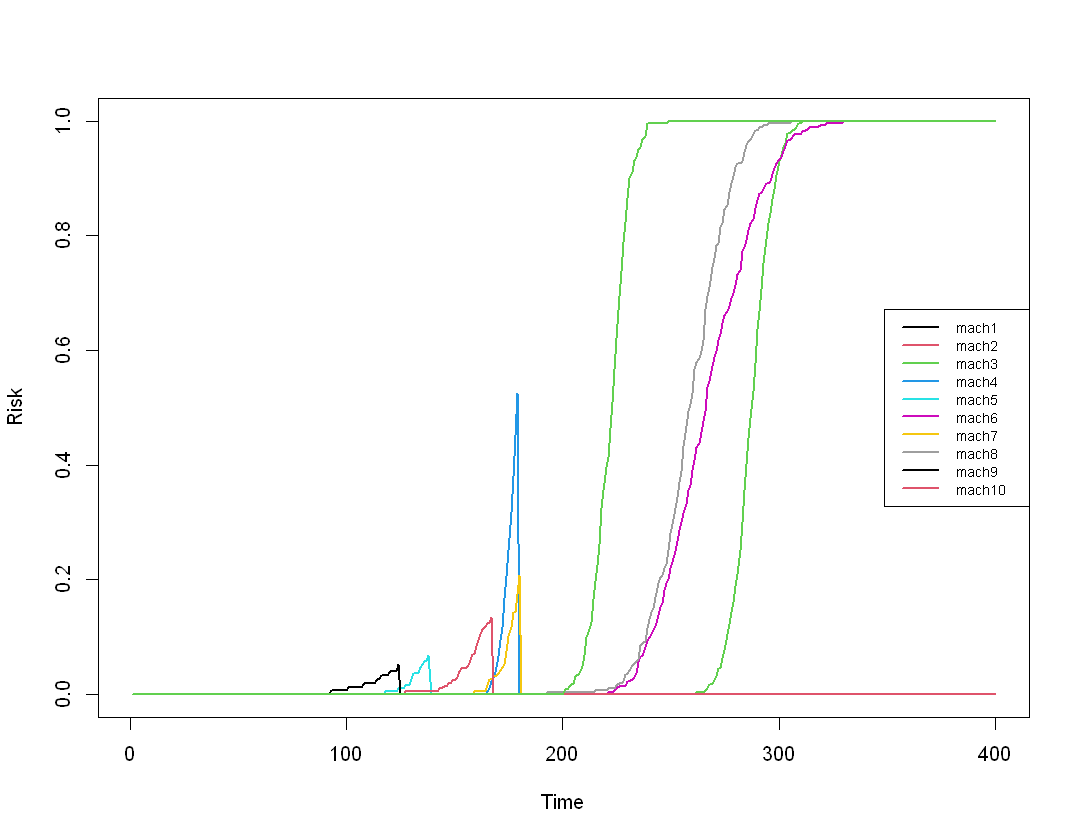

In [37]:
par(mfrow = c(1,1))
plot(1:nrow(risk_info), risk_info[,2] , type = 'l', lwd = 2, 
     xlab = 'Time', ylab = 'Risk', col = 1,
     ylim = c(0,1))
for (i in 2:10) {
  lines(1:nrow(risk_info), risk_info[,i], type = 'l', lwd = 2, col = i + 1)
}
legend('right', c('mach1', 'mach2', 'mach3', 'mach4', 'mach5', 'mach6', 'mach7',
                  'mach8', 'mach9', 'mach10'),
       col = seq(1:10), lwd = 2, cex = 0.7)